# Tweet Topic Modelling

In this notebook we'll model the important few topics in a single document, and look at how that changes over time. In our case since a single tweet is unlikely to have more than one topic, we will treat an entire __day of tweets__ as a document. The corpus consists of all 731 documents (365 days in 2019 and 366 days in 2020).

It will be interesting to see what the dominant topic is each day, how that has changed over the last two years, and which topics have persisted.

In [1]:
import datetime
import os
import json
import itertools
import gensim

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('seaborn')

### Loading from a corpus in chunks with gensim

Create a corpus which only opens documents when required.

In [2]:
from processing import StreamingCorpus

def head(corpus, n=10):
    return list(itertools.islice(corpus, n))

In [3]:
corpus = StreamingCorpus(data_dir='tweets_data')

Example (raw tweet content):

In [4]:
sample_files = [os.path.join('tweets_data', x) for x in os.listdir('tweets_data') if x.endswith('.json')][:3]

for file_loc in sample_files:     
    with open(file_loc, 'r') as f:
        lines = [line for line in f.read().split('\n') if len(line) > 0]
        document = ' '.join([json.loads(x)['content'] for x in lines])
        print(document[:100])

@ObiWokKanobe @carriesymonds @BorisJohnson OMG how could she bonk all that blubber.. @CPierceUK @dan
@BorisJohnson Dear Boris Johnson, I have to apprise you of a few facts which are testifying to a nuc
@RespectIsVital The award for despicable shithousery has to go to the currently invisible @BorisJohn


Example (normalized):

In [5]:
for i, doc in enumerate(corpus):
    if i == 3:
        break
    print(doc[:10])

['omg', 'could', 'bonk', 'blubber', 'guessing', 'right', 'long', 'got', 'someone', 'still']
['dear', 'apprise', 'fact', 'testifying', 'nuclear', 'war', 'peril', 'thanks', 'andrei', 'bystrov']
['award', 'despicable', 'shithousery', 'ha', 'go', 'currently', 'invisible', 'forgotten', 'horrid', 'scumbaggery']


In [6]:
first_five_documents = head(corpus, 5)
first_five_documents[2][:3]

['award', 'despicable', 'shithousery']

### Identify frequent collocations

Before feature engineering and vectorization, we want to extract some useful bi-gram based phrases from our tweets and remove some unnecessary terms. We leverage the `gensim.models.Phrases` class for this. This capability helps us automatically detect common phrases from a stream of sentences, which are typically multi-word expressions/word n-grams.

In [7]:
bigram = gensim.models.Phrases(
    corpus, 
    min_count=1000,  # must appear at least this number of times in the entire corpus
    threshold=20,    # higher threshold fewer phrases
    delimiter=b'_'   # join bigrams with an underscore
)
bigram_model = gensim.models.phrases.Phraser(bigram)

Save bigram model for later.

In [8]:
bigram_model.save('models/bigram_model_tweets.sav')

In [9]:
bigram_corpus = StreamingCorpus(data_dir='tweets_data', phraser=bigram_model)

Some collocations it's identifying in the first document, dated 2019-01-01, are `united_kingdom`, `nh_billion` (NHS and billion), `january_owes`.

In [10]:
print(head(bigram_corpus, 5)[1][:100])

['dear', 'apprise', 'fact', 'testifying', 'nuclear', 'war', 'peril', 'thanks', 'andrei', 'bystrov', 'would', 'bit', 'odd', 'though', 'odd', 'getting', 'back', 'searching', 'name', 'least', 'distinguished', 'minister', 'never', 'apologise', 'opinion', 'letter', 'magnificent', 'though', 'glad', 'top', 'yes', 'sir', 'rebuild', 'better', 'european', 'market', 'trade', 'many', 'country', 'unite', 'friendship', 'good', 'trade', 'unite', '30pm', '2nd', 'january_owes', 'nh_billion', 'unite', 'country', 'kashmir', 'stand', 'sir', 'bring', 'kashmiri', 'unite', 'true', 'leave', 'united_kingdom', 'mean', 'united_kingdom', 'yes', 'sir', 'stay', 'eu', 'build', 'better', 'future', 'trade', 'agree', 'build', 'united', 'european', 'country', 'men', 'nationality', 'unite', 'friendship', 'peace', 'war', 'better', 'european', 'market', 'amen', 'sir', 'yes', 'sir', 'united', 'mean', 'unite', 'work', 'trade', 'nationality', 'unite', 'forgetting', 'medical', 'insurance', 'ehic', 'still', 'valid']


## Create the training corpus

Create a dictionary representation of the documents (this stage can take a lot of time).

In [11]:
dictionary = gensim.corpora.Dictionary(document for document in bigram_corpus)

In [12]:
dictionary.save('models/full_dictionary.sav')

In [13]:
print('Total number of documents:', dictionary.num_docs)

Total number of documents: 731


In [14]:
dictionary.num_pos

134670209

The vocabulary is way too big - around 700k words.

In [15]:
print('Total Vocabulary Size:', len(dictionary))
print('Sample word to number mappings:', list(dictionary.items())[1000:1015])

Total Vocabulary Size: 715736
Sample word to number mappings: [(1000, 'inclined'), (1001, 'include'), (1002, 'included'), (1003, 'inclusive'), (1004, 'incompetence'), (1005, 'incorrectly'), (1006, 'increase'), (1007, 'increased'), (1008, 'increasing'), (1009, 'indeed'), (1010, 'independence'), (1011, 'independent'), (1012, 'indiafirst'), (1013, 'indicator'), (1014, 'individual')]


What are the most common words in the first document (2019-01-01)?

In [16]:
bow_doc = [dictionary.doc2bow(text) for text in head(bigram_corpus, 1)][0]

In [17]:
most_common_few = sorted(bow_doc, key=lambda x: x[1], reverse=True)[:3]
print([(head(bigram_corpus, 1)[0][most_index], most_count) for most_index, most_count in most_common_few])

[('brexiteer', 77), ('long', 50), ('service', 48)]


Let's prune the dictionary, keeping terms which appear in at least 7 days and also only keep the 10000 most frequent terms.

In [18]:
dictionary.filter_extremes(no_below=7, keep_n=10000, no_above=0.95)
print('Total Vocabulary Size:', len(dictionary))

Total Vocabulary Size: 10000


In [19]:
dictionary.save('models/filtered_dictionary.sav')

In [20]:
bow_doc = [dictionary.doc2bow(text) for text in head(bigram_corpus, 1)][0]

Create a bag-of-words corpus based on this pruned dictionary.

In [22]:
from processing import BagOfWordsStreamingCorpus

In [23]:
bow_corpus = BagOfWordsStreamingCorpus(dictionary, phraser=bigram_model)

# Build a topic model

Reload from previous:

In [24]:
# from processing import BagOfWordsStreamingCorpus, StreamingCorpus

# bigram_model = gensim.models.Phrases.load('models/bigram_model_tweets.sav')
# dictionary = gensim.corpora.Dictionary.load('models/filtered_dictionary.sav')

# bow_corpus = BagOfWordsStreamingCorpus(dictionary, phraser=bigram_model)
# bigram_corpus = StreamingCorpus(phraser=bigram_model)

### Latent Dirichlet Allocation (LDA) models

LDA models are pretty popular for topic modelling, and can be seen as a form of dimensionality reduction. [https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation).

Each document is assumed to have a combination of topics similar to a probabilistic Latent Semantic Indexing model, and in this case, the latent topics contain a Dirichlet prior over them.

### MALLET

We'll train a model using MALLET for computational efficiency.

In [ ]:
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip -q mallet-2.0.8.zip

In [25]:
MALLET_PATH = 'mallet-2.0.8\\bin\\mallet'

In [26]:
os.environ['MALLET_HOME'] = 'C:\\Users\\ollie\\Code\\BoJo-tweets\\mallet-2.0.8'

### Evaluating model performance
Since it's an unsupervised ML model, evaluating performance is a fairly tricky task. We don't have "truth" labels as to what the real N topics are.

`gensim` has an in-built Coherence Score used to measure the quality of topic models to some extent, the higher the coherence score the better. A set of statements is said to be _coherent_ if they support each other. We can also look at model perplexity, the lower the perplexity the better.

## Training
We'll train multiple models, optimising the coherence score over $N$ (the number of topics). Each model takes around 1.5 hours to train using MALLET and then just under an hour to compute the entire coherence score, so we'll leave this running overnight.

In [27]:
import tqdm

def topic_model_coherence_generator(corpus, texts, dictionary, start_topic_count, end_topic_count, step, cpus=1):
    
    models = []
    coherence_scores = []
    for topic_nums in tqdm.tqdm(range(start_topic_count, end_topic_count+1, step)):
        mallet_lda_model = gensim.models.wrappers.LdaMallet(mallet_path=MALLET_PATH, corpus=corpus,
                                                            num_topics=topic_nums, id2word=dictionary,
                                                            workers=cpus)
        cv_coherence_model_mallet_lda = gensim.models.CoherenceModel(model=mallet_lda_model, corpus=corpus, 
                                                                     texts=texts, dictionary=dictionary, 
                                                                     coherence='c_v')
        coherence_score = cv_coherence_model_mallet_lda.get_coherence()
        coherence_scores.append(coherence_score)
        models.append(mallet_lda_model)
    
    return models, coherence_scores

In [28]:
lda_models, coherence_scores = topic_model_coherence_generator(
    corpus=bow_corpus, texts=bigram_corpus, dictionary=dictionary, 
    start_topic_count=5, end_topic_count=15, step=1, cpus=4
)

100%|█████████████████████████████████████████████████████████████████████████████| 11/11 [26:06:44<00:00, 8545.85s/it]


In [29]:
coherence_df = pd.DataFrame({'Number of Topics': range(5, 16, 1),
                             'Coherence Score': np.round(coherence_scores, 4)})
coherence_df.sort_values(by=['Coherence Score'], ascending=False).head(10)

,Number of Topics,Coherence Score
6,11,0.5194
7,12,0.5189
5,10,0.5161
8,13,0.5143
10,15,0.5093
4,9,0.5044
9,14,0.5041
3,8,0.4914
2,7,0.4827
0,5,0.4618


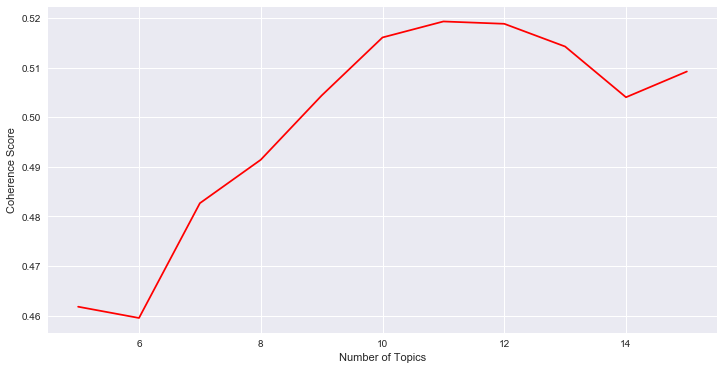

In [30]:
x_ax = range(5, 16, 1)
y_ax = coherence_scores
plt.figure(figsize=(12, 6))
plt.plot(x_ax, y_ax, c='r')
plt.rcParams['figure.facecolor'] = 'white'
xl = plt.xlabel('Number of Topics')
yl = plt.ylabel('Coherence Score')
plt.show()

Select best topic number as 11.

In [31]:
best_model_idx = coherence_df[coherence_df['Number of Topics'] == 11].index[0]
best_lda_model = lda_models[best_model_idx]
best_lda_model.num_topics

11

Save best LDA model.

In [32]:
best_lda_model.save('models/best_lda_model.sav')

## What are the topics?

In [33]:
topics = [[(term, round(wt, 3)) 
               for term, wt in best_lda_model.show_topic(n, topn=10)] 
                   for n in range(0, best_lda_model.num_topics)]

for idx, topic in enumerate(topics):
    print('Topic #'+str(idx+1)+':')
    print([term for term, wt in topic])
    print()

Topic #1:
['christmas', 'tier', 'vaccine', 'oven_ready', 'fish', 'xmas', 'biden', 'fishing', 'walk_away', 'nodealbrexit']

Topic #2:
['mask', 'pay_rise', 'teacher', 'pandemic', 'pmqs', 'pub', 'staff', 'holiday', 'nurse', 'shop']

Topic #3:
['extension', 'backstop', 'queen', 'stopthecoup', 'dup', 'mandate', 'surrender', 'stopbrexit', 'ditch', 'october']

Topic #4:
['coronavirus', 'virus', 'lockdown', 'staff', 'stay_home', 'pier', 'self_employed', 'italy', 'essential', 'lock']

Topic #5:
['lockdown', 'virus', 'test', 'pandemic', 'testing', 'vaccine', 'science', 'restriction', 'coronavirus', 'scientist']

Topic #6:
['congratulation', 'unite', 'hunt', 'world_poorest', 'mandate', 'nh_billion', 'backboris', 'congrats', 'victory', 'race']

Topic #7:
['protest', 'statue', 'thug', 'violence', 'riot', 'terrorist', 'protester', 'khan', 'race', 'weekend']

Topic #8:
['cummings', 'dominic_cummings', 'sack', 'dominiccummings', 'lockdown', 'parent', 'drive', 'dom', 'mile', 'durham']

Topic #9:
['hs2'

And the relative word contribution to each of these topics:

In [34]:
for topic_id, topic in best_lda_model.print_topics(num_topics=best_lda_model.num_topics, num_words=10):
    print('Topic #'+str(topic_id+1)+':')
    print(topic)
    print()

Topic #1:
0.019*"christmas" + 0.015*"tier" + 0.013*"vaccine" + 0.006*"oven_ready" + 0.006*"fish" + 0.005*"xmas" + 0.005*"biden" + 0.004*"fishing" + 0.004*"walk_away" + 0.003*"nodealbrexit"

Topic #2:
0.008*"mask" + 0.006*"pay_rise" + 0.005*"teacher" + 0.005*"pandemic" + 0.005*"pmqs" + 0.005*"pub" + 0.005*"staff" + 0.004*"holiday" + 0.003*"nurse" + 0.003*"shop"

Topic #3:
0.005*"extension" + 0.004*"backstop" + 0.004*"queen" + 0.003*"stopthecoup" + 0.003*"dup" + 0.002*"mandate" + 0.002*"surrender" + 0.002*"stopbrexit" + 0.002*"ditch" + 0.002*"october"

Topic #4:
0.017*"coronavirus" + 0.011*"virus" + 0.011*"lockdown" + 0.010*"staff" + 0.007*"stay_home" + 0.007*"pier" + 0.006*"self_employed" + 0.006*"italy" + 0.006*"essential" + 0.006*"lock"

Topic #5:
0.027*"lockdown" + 0.015*"virus" + 0.008*"test" + 0.005*"pandemic" + 0.004*"testing" + 0.004*"vaccine" + 0.004*"science" + 0.003*"restriction" + 0.003*"coronavirus" + 0.003*"scientist"

Topic #6:
0.008*"congratulation" + 0.004*"unite" + 0.00

The intertopic distance map is a visualization of the topics in a two-dimensional space . The area of these topic circles is proportional to the amount of words that belong to each topic across the dictionary.

In [35]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [36]:
import pyLDAvis
import pyLDAvis.gensim

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(
    gensim.models.wrappers.ldamallet.malletmodel2ldamodel(best_lda_model), 
    bow_corpus, 
    dictionary
)
pyLDAvis.save_html(vis, 'images/LDAvis_plot.html')
vis

C:\Users\ollie\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
C:\Users\ollie\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / term_proportion)
C:\Users\ollie\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:241: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.063443  0.004490       1        1  15.342707
8      0.048559 -0.070652       2        1  15.289663
2      0.075229 -0.028622       3        1  13.403990
5      0.079403 -0.004140       4        1  10.035967
1     -0.006361 -0.045929       5        1   8.828551
10     0.041772 -0.012863       6        1   8.093409
3     -0.161535 -0.025479       7        1   8.051834
0      0.025502 -0.100738       8        1   6.366281
9     -0.138891  0.021361       9        1   5.208424
7     -0.024206  0.166614      10        1   5.079686
6      0.123969  0.095959      11        1   4.299489, topic_info=     Category           Freq              Term          Total  loglift  \
term                                                                     
2949  Default  134764.000000          cummings  134764.000000  30.0000   
9104  Default  225152.000000          lockdown  225152.000000  29.0000   
6339  Default  165483.000000             virus  165483.000000  28.0000   
9998  Default  110259.000000       coronavirus  110259.000000  27.0000   
1806  Default   53719.000000         christmas   53719.000000  26.0000   
9737  Default   54356.000000               ppe   54356.000000  25.0000   
3492  Default   38957.000000  dominic_cummings   38957.000000  24.0000   
1664  Default   36456.000000              tier   36456.000000  23.0000   
9895  Default   62943.000000           vaccine   62943.000000  22.0000   
916   Default   89268.000000             staff   89268.000000  21.0000   
1959  Default   91688.000000          hospital   91688.000000  20.0000   
2092  Default   33244.000000           protest   33244.000000  19.0000   
2204  Default   92556.000000              test   92556.000000  18.0000   
7979  Default   29132.000000          recovery   29132.000000  17.0000   
176   Default   77046.000000             china   77046.000000  16.0000   
820   Default   37033.000000              sack   37033.000000  15.0000   
1224  Default   36232.000000    congratulation   36232.000000  14.0000   
3311  Default   55819.000000           testing   55819.000000  13.0000   
9685  Default   80037.000000          pandemic   80037.000000  12.0000   
5943  Default   52348.000000              mask   52348.000000  11.0000   
3151  Default   48719.000000             nurse   48719.000000  10.0000   
2749  Default   34759.000000         stay_home   34759.000000   9.0000   
8499  Default   17949.000000            statue   17949.000000   8.0000   
7053  Default   21279.000000            ge2019   21279.000000   7.0000   
691   Default   31237.000000          pay_rise   31237.000000   6.0000   
2979  Default   20572.000000   dominiccummings   20572.000000   5.0000   
6255  Default   37604.000000              pier   37604.000000   4.0000   
2622  Default   55213.000000            parent   55213.000000   3.0000   
4654  Default   51278.000000               pub   51278.000000   2.0000   
9462  Default   23415.000000     self_employed   23415.000000   1.0000   
...       ...            ...               ...            ...      ...   
4220  Topic11     984.897644            famine    1445.700243   2.7629   
1691  Topic11   10467.329703          violence   15711.332830   2.7406   
891   Topic11    3372.005233           slavery    5158.499534   2.7215   
5993  Topic11    2493.720220            racial    3981.851913   2.6787   
9665  Topic11     842.747469          systemic    1362.846464   2.6660   
6603  Topic11    2354.616120          heritage    3881.858760   2.6467   
553   Topic11    7720.785242              khan   12828.489065   2.6389   
3135  Topic11    5959.138425               mob   10703.781405   2.5610   
5004  Topic11    3394.343117              bame    5788.917480   2.6128   
890   Topic11    4202.568400             slave    7792.303813   2.5292   
2373  Topic11    3740.580330           condemn    8276.614272   2.3525   

![title](images/LDAvis_plot.png)

The above `.png` image is a static version of the original HTML. Since you can't hover over the blobs, note that the numbers on the intertopic map correspond to: 
* 1: Coronavirus testing / Science
* 2: International and Domestic policies
* 3: Brexit
* 4: Election-related #BackBoris (positive)
* 5: Lockdown (masks, pubs)
* 6: Election-related #LiarJohnson (negative)
* 7: Lockdown (stay home, essential travel)
* 8: Christmas Vaccine
* 9: Hospitals / Hygiene
* 10: Dominic Cummings
* 11: BLM protests
    
These numberings are different from the topic numbers in the next section, and are listed here only for convenience.

## Topics over time

Let's look at, for each document (day of tweets), what are the main topics.

In [37]:
lda_model_results = best_lda_model[bow_corpus]

In [38]:
corpus_topics = [sorted(topics, key=lambda record: -record[1])[0] 
                     for topics in lda_model_results]

In [39]:
len(corpus_topics)

731

Try out different values of `topn`.

In [40]:
TOPICS = [
    ', '.join([term for term, _ in best_lda_model.show_topic(n, topn=10)])
    for n in range(0, best_lda_model.num_topics)
]

In [42]:
TOPICS

['christmas, tier, vaccine, oven_ready, fish, xmas, biden, fishing, walk_away, nodealbrexit',
 'mask, pay_rise, teacher, pandemic, pmqs, pub, staff, holiday, nurse, shop',
 'extension, backstop, queen, stopthecoup, dup, mandate, surrender, stopbrexit, ditch, october',
 'coronavirus, virus, lockdown, staff, stay_home, pier, self_employed, italy, essential, lock',
 'lockdown, virus, test, pandemic, testing, vaccine, science, restriction, coronavirus, scientist',
 'congratulation, unite, hunt, world_poorest, mandate, nh_billion, backboris, congrats, victory, race',
 'protest, statue, thug, violence, riot, terrorist, protester, khan, race, weekend',
 'cummings, dominic_cummings, sack, dominiccummings, lockdown, parent, drive, dom, mile, durham',
 'hs2, china, iran, snp, india, terrorist, scottish, muslim, green, ban',
 'ppe, hospital, coronavirus, recovery, virus, china, staff, test, patient, nurse',
 'ge2019, hospital, nurse, scrutiny, coward, liarjohnson, marr, poverty, terrorist, releas

It's interesting to note that the model has picked out two different election-related topics, one consisting of positive sentiments ("#BackBoris" hashtag, "congratulations", "unite" the country, "victory") and the other mostly containing negative sentiments ("#LiarJohnson" and "#ge2019" hashtags suggesting another general election, "scrutiny", "coward", "poverty").

There are also several topics relating to lockdown, but each comes from a slightly different perspective.

In [45]:
TOPIC_DESCRIPTIONS = {
    1: 'Christmas Vaccine',
    2: 'Lockdown (masks, pubs)',
    3: 'Brexit',
    4: 'Lockdown (stay home, essential travel)',
    5: 'Coronavirus testing / Science',
    6: 'Election-related #BackBoris (positive)',
    7: 'BLM protests',
    8: 'Dominic Cummings',
    9: 'International and Domestic policies',
    10: 'Hospitals / Hygiene',
    11: 'Election-related #LiarJohnson (negative)'
}
"""
Human-labelled topic descriptions. It helps that the topics are fairly interpretable.
There are some topics which are very related (for example, Lockdown and Coronavirus) but
the keywords suggest they are talking about the topic from two different angles (in this
example, one is about restrictive policies and the other about the virus itself).
"""

'\nHuman-labelled topic descriptions. It helps that the topics are fairly interpretable.\nThere are some topics which are very related (for example, Lockdown and Coronavirus) but\nthe keywords suggest they are talking about the topic from two different angles (in this\nexample, one is about restrictive policies and the other about the virus itself).\n'

In [46]:
from utils import get_date_from_file_loc

def format_topics_sentences(lda_model_results, corpus, data_dir='tweets_data'):

    files_lst = [os.path.join(data_dir, x) 
                      for x in os.listdir(data_dir) if x.endswith('.json')]
    
    corpus_topics = [sorted(topics, key=lambda record: -record[1])[0] 
                     for topics in lda_model_results]
    topic_terms = [', '.join([term for term, wt in topic])  
                              for topic in topics]
    
    corpus_topic_df = pd.DataFrame()
    corpus_topic_df['document_id'] = range(0, len(files_lst))
    corpus_topic_df['date'] = [get_date_from_file_loc(filename) for filename in files_lst]
    
    corpus_topic_df['Dominant Topic'] = [item[0]+1 for item in corpus_topics]
    corpus_topic_df['Dominant Topic Contribution %'] = [round(item[1]*100, 2) for item in corpus_topics]
    corpus_topic_df['Dominant Topic Label'] = [TOPIC_DESCRIPTIONS[item[0]+1] for item in corpus_topics]
    corpus_topic_df['Dominant Topic Description'] = [TOPICS[item[0]] for item in corpus_topics]
    
    return corpus_topic_df 

In [47]:
corpus_topic_df = format_topics_sentences(lda_model_results, bow_corpus)

### Most representative day for a given topic

In [48]:
corpus_topic_df.sort_values('Dominant Topic Contribution %', ascending=False)\
    .groupby('Dominant Topic').head(1).sort_values('date')

,document_id,date,Dominant Topic,Dominant Topic Contribution %,Dominant Topic Label,Dominant Topic Description
190,190,2019-07-10,6,81.15,Election-related #BackBoris (positive),"congratulation, unite, hunt, world_poorest, ma..."
291,291,2019-10-19,3,88.52,Brexit,"extension, backstop, queen, stopthecoup, dup, ..."
343,343,2019-12-10,11,77.98,Election-related #LiarJohnson (negative),"ge2019, hospital, nurse, scrutiny, coward, lia..."
374,374,2020-01-10,9,94.18,International and Domestic policies,"hs2, china, iran, snp, india, terrorist, scott..."
448,448,2020-03-24,4,83.98,"Lockdown (stay home, essential travel)","coronavirus, virus, lockdown, staff, stay_home..."
461,461,2020-04-06,10,82.74,Hospitals / Hygiene,"ppe, hospital, coronavirus, recovery, virus, c..."
509,509,2020-05-24,8,73.10,Dominic Cummings,"cummings, dominic_cummings, sack, dominiccummi..."
529,529,2020-06-13,7,71.61,BLM protests,"protest, statue, thug, violence, riot, terrori..."
594,594,2020-08-17,2,59.96,"Lockdown (masks, pubs)","mask, pay_rise, teacher, pandemic, pmqs, pub, ..."
669,669,2020-10-31,5,68.92,Coronavirus testing / Science,"lockdown, virus, test, pandemic, testing, vacc..."


The day with the most dominant Brexit tweet topic was 2019-10-19, just a week or two before the big 31st October deadline. Most of these representative days make sense.

### Dominant topic over time

In [70]:
import matplotlib.colors as mcolors

COLOUR_CODES = list(mcolors.TABLEAU_COLORS.values()) + ['teal']

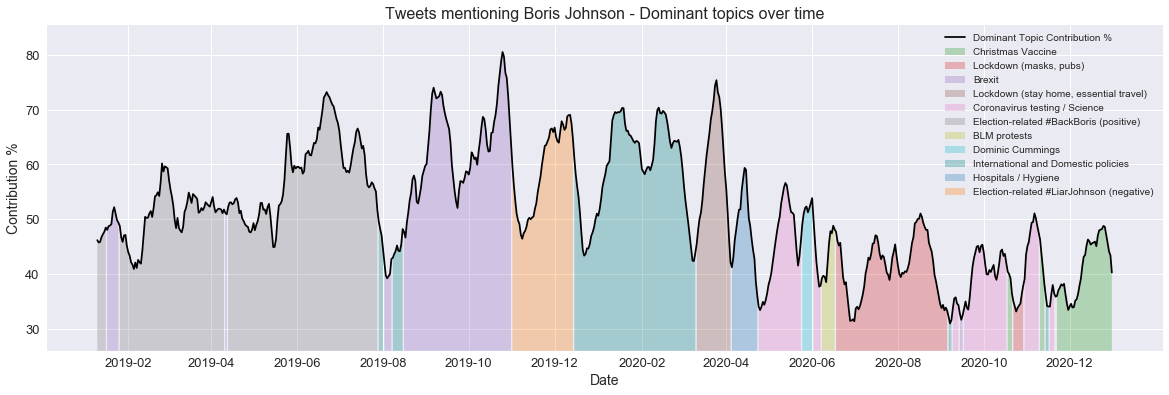

In [82]:
from scipy.stats import mode
corpus_topic_df['dominant_topic_rolling'] = corpus_topic_df['Dominant Topic'].rolling(5).apply(lambda x: mode(x)[0])
corpus_topic_df['contribution_rolling'] = corpus_topic_df['Dominant Topic Contribution %'].rolling(10).mean()
corpus_topic_df['date'] = pd.to_datetime(corpus_topic_df['date'])

ax = corpus_topic_df.set_index('document_id')['contribution_rolling'].plot(figsize=(20, 6), color='black')

for i in range(len(TOPICS)):
    ax.fill_between(
        range(len(corpus_topic_df['document_id'])), 
        corpus_topic_df['contribution_rolling'].min(skipna=True)-5, 
        corpus_topic_df['contribution_rolling'],
        where=(corpus_topic_df['dominant_topic_rolling'] == i+1),
        alpha=0.3,
        facecolor=COLOUR_CODES[(i+2)%len(COLOUR_CODES)]
    )
    
ax.legend(labels=['Dominant Topic Contribution %']+list(TOPIC_DESCRIPTIONS.values()))
ax.set_ylim(corpus_topic_df['contribution_rolling'].min(skipna=True)-5, corpus_topic_df['contribution_rolling'].max(skipna=True)+5)
ax.set_title('Tweets mentioning Boris Johnson - Dominant topics over time', fontsize=16)
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Contribution %', fontsize=14)


# Format x ticks 
tick_filter = (corpus_topic_df.date.dt.day == 1) & (corpus_topic_df.date.dt.month % 2 == 0)
plt.xticks(corpus_topic_df.loc[tick_filter, 'document_id'], corpus_topic_df.loc[tick_filter, 'date'].dt.strftime('%Y-%m'), fontsize=13)
plt.yticks(fontsize=13)

plt.savefig('images/Dominant_topics_over_time.png')
plt.show()